In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
def split(img):
    h,w,c = img.shape
    i1 = img[:,0:w//2,:]
    i2 = img[:,w//2:w,:]
    return i1,i2

## Intensity Window Based correlation

In [5]:
def correlation(patch1, patch2):
    if patch1.std() == 0 or patch2.std() == 0:
        return 0
    num = np.mean((patch1 - patch1.mean())*(patch2 - patch2.mean()))
    denom = (patch1.std() * patch2.std())
    return num/denom

In [6]:
def keypoints(img,window,stride):
    piv = []
    w = window//2
    for j in range(w,img.shape[0]-w,stride):
        for i in range(w,img.shape[1]-w,stride):
            piv.append((i,j))
    return np.asarray(piv)

In [20]:
def match(img1,img2, window=25,stride=20,show=True):
#     img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
#     img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    l = window//2
    r = window//2-1
    
    r1,c1 = img1.shape[:2]
    r2,c2 = img2.shape[:2]
    
    nptsA = keypoints(img1,window,stride)
    nptsB = keypoints(img2,window,stride)
    
    dist = np.zeros((nptsA.shape[0],nptsB.shape[0]))
    for i in range(nptsA.shape[0]):
        a = nptsA[i]
        p1 = img1[a[1]-l:a[1]+r+1,a[0]-l:a[0]+r+1]
        for j in range(nptsB.shape[0]):
            b = nptsB[j]
            p2 = img2[b[1]-l:b[1]+r+1,b[0]-l:b[0]+r+1]
            dist[i,j] = correlation(p1,p2)
    
    matchesA = nptsA.astype('int32')
    matchesB = np.int32([nptsB[np.argmax(dist[i])] for i in range(nptsA.shape[0])])
    return matchesA,matchesB

In [21]:
def mapping(img,k1,k2,window_size,thickness=1):
    nimg = img.copy()
    h,w,c = nimg.shape
    plt.figure(figsize=(10,20))
    for i in range(len(k1)):
        pt1 = (k1[i][1]+window_size//2,k1[i][0]+window_size//2)
        pt2 = (k2[i][1]+window_size//2+w//2,k2[i][0]+ window_size//2)
        line_img = cv2.line(nimg,tuple(pt1),(pt2),(0,0,225),thickness)
    plt.imshow(nimg)
    plt.show()

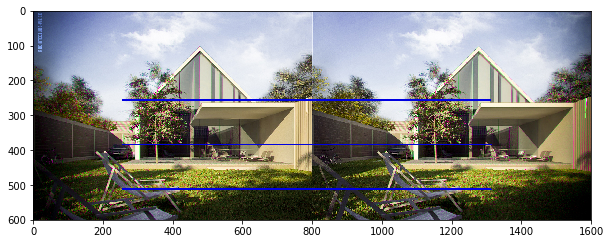

In [43]:
img = cv2.imread('stereo_images/1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
i1,i2 = split(img)
k1,k2 = match(i1,i2,window=256,stride=128)
mapping(img,k1,k2,256,3)

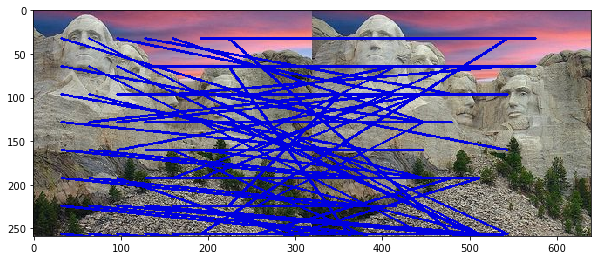

In [23]:
img = cv2.imread('stereo_images/2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
i1,i2 = split(img)
k1,k2 = match(i1,i2,window=32,stride=32)
mapping(img,k1,k2,32,2)

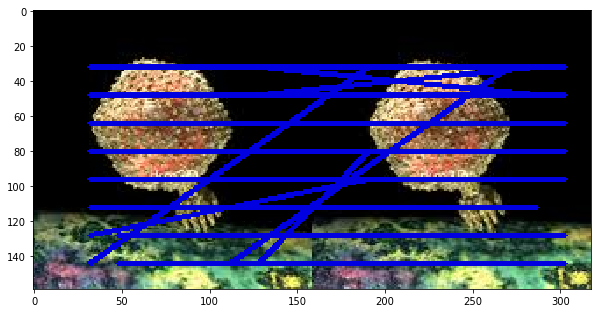

In [46]:
img = cv2.imread('stereo_images/3.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
i1,i2 = split(img)
k1,k2 = match(i1,i2,32,16)
mapping(img,k1,k2,32,2)


We perform greedy search on intensity windows. Basically we do exhaustive search over all windows and store the window values with highest correlation. Once we get that we map the stereo pairs. We use these stereo pairs for stereo rectification. As we can see since its only dependent on intensity, they are not really localized and therefore the mapping is all over the place

## Stereo Rectification

In [53]:
def rectify_images_window(image_A, image_B, window_size=64, stride=64):
    """Rectify two stereo images."""
    print("Finding matching points")
    match_A, match_B = match(image_A, image_B, window_size, stride)
    
    print("Finding Fundamantel Matrix")
    F, mask = cv2.findFundamentalMat(match_A, match_B)

    print("Computing homography")
    ret, H1, H2 = cv2.stereoRectifyUncalibrated(match_A, match_B, F, image_A.shape[0:2])

    print("Rectifying images")
    h,w,c = image_A.shape
    new_img_A = cv2.warpPerspective(image_A, H1, (w,h))
    new_img_B = cv2.warpPerspective(image_B, H2, (w,h))

    return new_img_A, new_img_B

In [54]:
def show_rectified(img_A, img_B):
    """Show the images side by side after rectification."""
    plt.figure(figsize=(10,20))
    (hA, wA) = img_A.shape[:2]
    (hB, wB) = img_B.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = img_A
    vis[0:hB, wA:] = img_B
    
    return vis

Finding matching points
Finding Fundamantel Matrix
Computing homography
Rectifying images


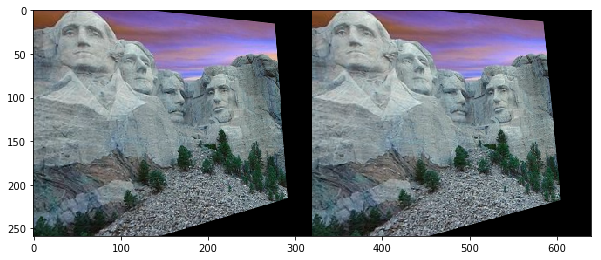

In [55]:
img = cv2.imread('stereo_images/2.jpg', 1)
i1,i2 = split(img)
new_img1, new_img2 = rectify_images_window(i1, i2, 32, 32)
plt.imshow(show_rectified(new_img1, new_img2))

Finding matching points
Finding Fundamantel Matrix
Computing homography
Rectifying images


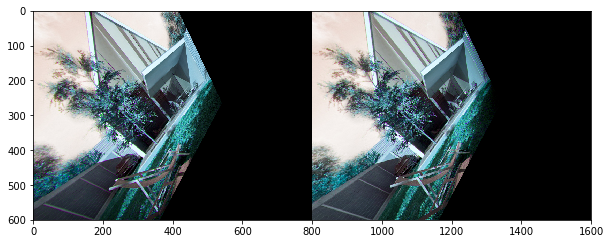

In [56]:
img = cv2.imread('stereo_images/1.jpg', 1)
i1,i2 = split(img)
new_img1, new_img2 = rectify_images_window(i1, i2, 256, 128)
plt.imshow(show_rectified(new_img1, new_img2))

Finding matching points
Finding Fundamantel Matrix
Computing homography
Rectifying images


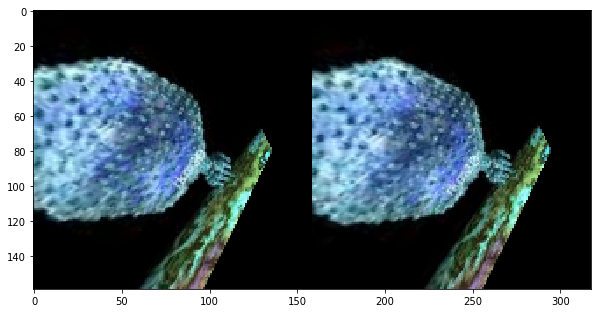

In [60]:
img = cv2.imread('stereo_images/3.jpeg', 1)
i1,i2 = split(img)
new_img1, new_img2 = rectify_images_window(i1, i2, 48, 16)
plt.imshow(show_rectified(new_img1, new_img2))

As mentioned above stereo rectification based on intensity doesnt perform well because the mapping is all over the place. 

## Dense ORB Matching
As the laptop doesnt support SIFT, we use ORB matching. The idea is still the same, we find the keypoints using orb algorithm and then we do rectification by projecting to the same plane.

In [76]:
def dense_orb_matching(img1,img2,min_match=500):
    orb = cv2.ORB_create(nfeatures=min_match)
    h,w,c = img1.shape

    g1 = cv2.cvtColor(img1,cv2.COLOR_RGB2BGR)
    k1,d1= orb.detectAndCompute(g1, None)
    g2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
    k2,d2= orb.detectAndCompute(g2, None)
#     key = np.int32([kp.pt for kp in keypoints])
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(d1,d2)
    matches = sorted(matches, key = lambda x:x.distance)[0:min_match]
    draw_params = dict(matchesMask=None,
                       singlePointColor=None,
                       flags=2)
        
    dis_im = cv2.drawMatches(img1,k1,img2,k2,matches,None,**draw_params)
    return k1,d1,k2,d2,matches,dis_im

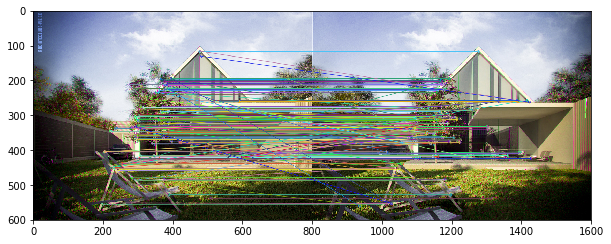

In [80]:
img = cv2.imread('stereo_images/1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
i1,i2 = split(img)
final = dense_orb_matching(i1,i2)
plt.figure(figsize=(10,20))
plt.imshow(final[-1])

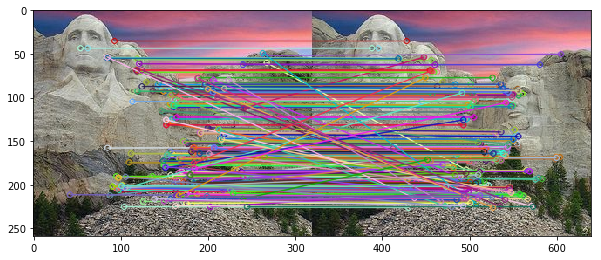

In [82]:
img = cv2.imread('stereo_images/2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
i1,i2 = split(img)
final = dense_orb_matching(i1,i2)
plt.figure(figsize=(10,20))
plt.imshow(final[-1])

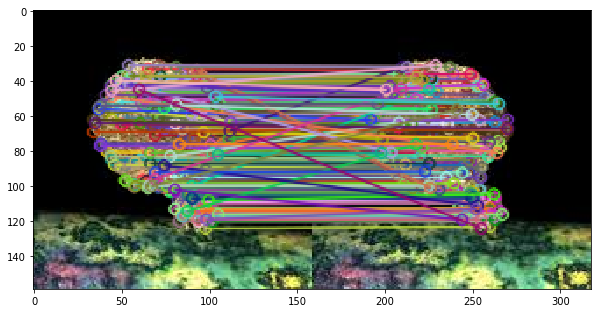

In [83]:
img = cv2.imread('stereo_images/3.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
i1,i2 = split(img)
final = dense_orb_matching(i1,i2)
plt.figure(figsize=(10,20))
plt.imshow(final[-1])

As we can say, the matching is much better which would help in far better rectification as compared to intensity matching

## Matching on Corresponding Line

### Greedy Matching 
+ Once we get the rectified images, now we try to map the points from one to another. 
+ The idea is that we do patch match along the epipolar lines and once we get a norm score greater than its neighbours we take that patch to be true. We use the epipolar constraint

### Dynamic Time Warping (DTW)

+ In time series analysis, dynamic time warping (DTW) is one of the algorithms for measuring similarity between two temporal sequences, which may vary in speed.   
+ We can use DTW to measure similarity between two horizontal scanlines in each image(as after rectification, epipolar lines are horizontal.)   
+ In this we construct a dp similar to edit distance where  
`dp[i][j] = min(dp[i-1][j],dp[i][j-1],dp[i-1][j-1])+score at that position   `  
+ Naturally this algorithm is faster than the greedy algo and exploits the optimal substructure in the core problem.